/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 2.0188 - mae: 0.9473 - val_loss: 0.4768 - val_mae: 0.4986
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5843 - mae: 0.5558 - val_loss: 0.4251 - val_mae: 0.4559
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4896 - mae: 0.5034 - val_loss: 0.4152 - val_mae: 0.4455
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4436 - mae: 0.4751 - val_loss: 0.3870 - val_mae: 0.4363
Epoch 5/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4277 - mae: 0.4677 - val_loss: 0.3965 - val_mae: 0.4307
Epoch 6/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4399 - mae: 0.4675 - val_loss: 0.3821 - val_mae: 0.4308
Epoch 7/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.3861 - mae: 0.4439 - val_loss: 0.3628 - val_mae: 0.4221
Epoch 8/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3893 - mae: 0.4486 - val_loss: 0.3880 - val_mae: 0.4285
Epoch 9/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/

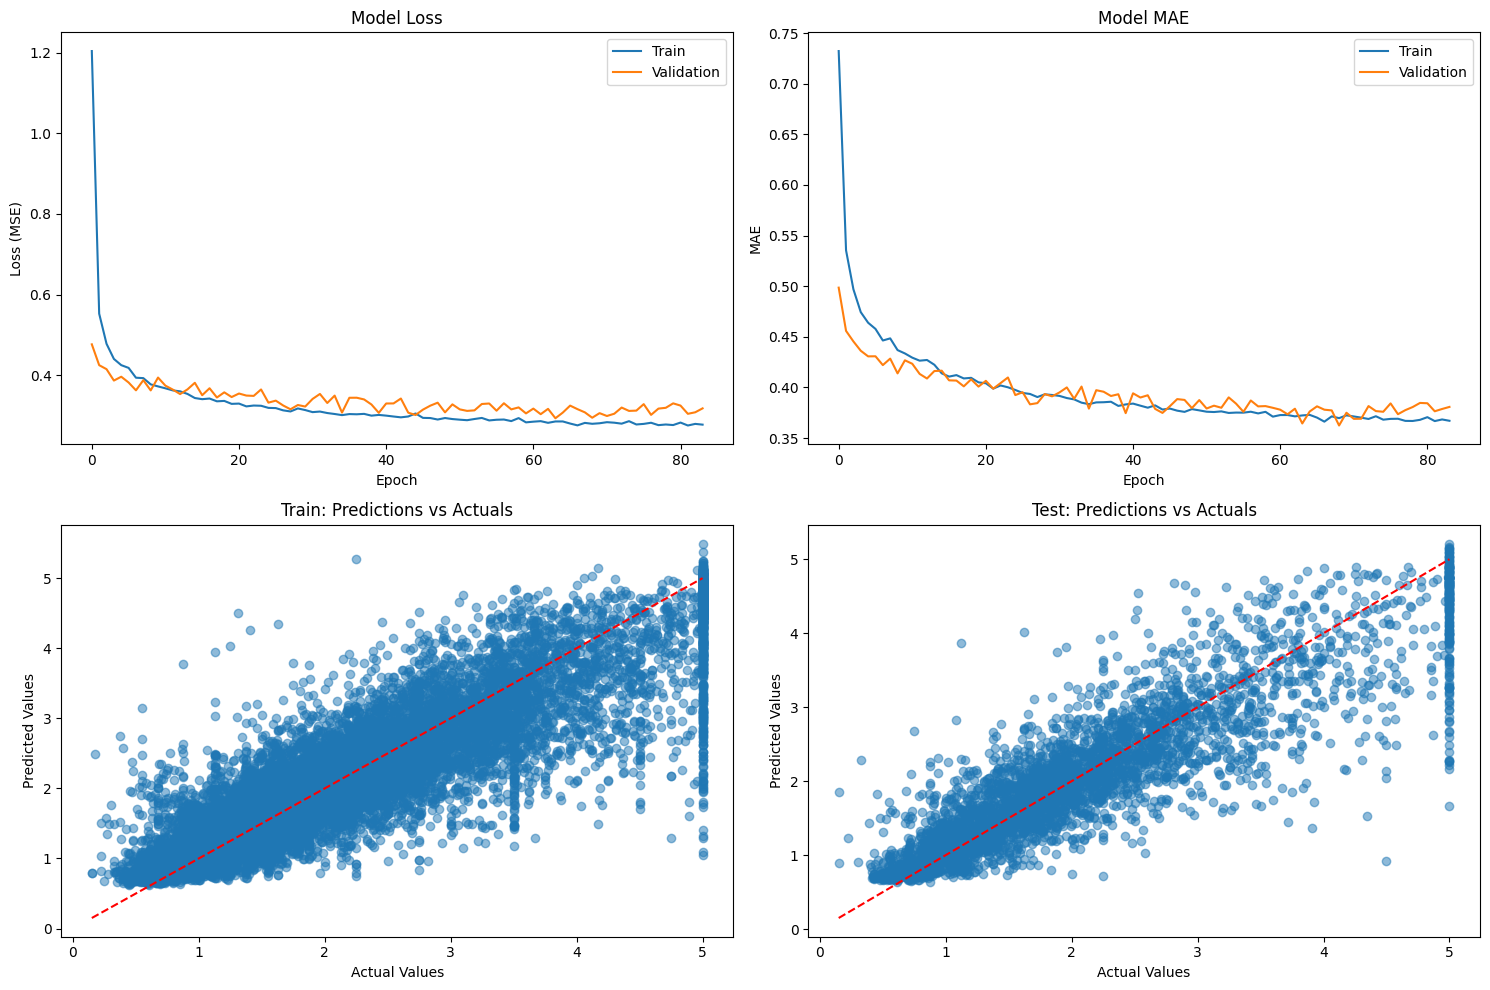

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

def load_data():
    data = fetch_california_housing()
    x = data.data
    y = data.target
    feature_names = data.feature_names

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=113
    )

    mean = x_train.mean(axis=0)
    std = x_train.std(axis=0)
    x_train = (x_train - mean) / std
    x_test = (x_test - mean) / std

    return (x_train, y_train), (x_test, y_test), mean, std, feature_names

def build_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='mse',
                  metrics=['mae'])

    return model

def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    return {
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'accuracy_percentage': r2 * 100
    }

def train_model(epochs=100, batch_size=32):
    (x_train, y_train), (x_test, y_test), mean, std, feature_names = load_data()
    model = build_model(x_train.shape[1])

    import tensorflow as tf
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=20, restore_best_weights=True)

    history = model.fit(
        x_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=1
    )
    return model, history, x_train, y_train, x_test, y_test, mean, std, feature_names

model, history, x_train, y_train, x_test, y_test, mean, std, feature_names = train_model()

y_train_pred = model.predict(x_train).flatten()
y_test_pred = model.predict(x_test).flatten()

train_metrics = calculate_metrics(y_train, y_train_pred)
test_metrics = calculate_metrics(y_test, y_test_pred)

print("\n===== Model Evaluation =====")
print("\nTraining Data Metrics:")
print(f"MAE: {train_metrics['mae']:.4f}")
print(f"MSE: {train_metrics['mse']:.4f}")
print(f"RMSE: {train_metrics['rmse']:.4f}")
print(f"R²: {train_metrics['r2']:.4f}")
print(f"Accuracy (R² as %): {train_metrics['accuracy_percentage']:.2f}%")

print("\nTest Data Metrics:")
print(f"MAE: {test_metrics['mae']:.4f}")
print(f"MSE: {test_metrics['mse']:.4f}")
print(f"RMSE: {test_metrics['rmse']:.4f}")
print(f"R²: {test_metrics['r2']:.4f}")
print(f"Accuracy (R² as %): {test_metrics['accuracy_percentage']:.2f}%")

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(2, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(2, 2, 3)
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Train: Predictions vs Actuals')

plt.subplot(2, 2, 4)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Test: Predictions vs Actuals')

plt.tight_layout()
plt.savefig('training_history.png')

params = {
    'mean': mean,
    'std': std,
    'feature_names': feature_names,
    'train_metrics': train_metrics,
    'test_metrics': test_metrics
}

with open('model_params.pkl', 'wb') as f:
    pickle.dump(params, f)

with open("A01665895_regressionmodel_housing_prices_cali.pkl", "wb") as model_file:
    pickle.dump(model, model_file)



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
def load_data():
    data = fetch_california_housing()
    x = data.data
    y = data.target
    feature_names = data.feature_names

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=113
    )

    mean = x_train.mean(axis=0)
    std = x_train.std(axis=0)
    x_train = (x_train - mean) / std
    x_test = (x_test - mean) / std

    return (x_train, y_train), (x_test, y_test), mean, std, feature_names

def build_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='mse',
                  metrics=['mae'])

    return model

def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    return {
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'accuracy_percentage': r2 * 100
    }

In [4]:
def train_model(epochs=100, batch_size=32):
    (x_train, y_train), (x_test, y_test), mean, std, feature_names = load_data()
    model = build_model(x_train.shape[1])

    import tensorflow as tf
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=20, restore_best_weights=True)

    history = model.fit(
        x_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=1
    )
    return model, history, x_train, y_train, x_test, y_test, mean, std, feature_names

In [5]:
model, history, x_train, y_train, x_test, y_test, mean, std, feature_names = train_model()

y_train_pred = model.predict(x_train).flatten()
y_test_pred = model.predict(x_test).flatten()

train_metrics = calculate_metrics(y_train, y_train_pred)
test_metrics = calculate_metrics(y_test, y_test_pred)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.6532 - mae: 1.0416 - val_loss: 0.4873 - val_mae: 0.4850
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5787 - mae: 0.5402 - val_loss: 0.4513 - val_mae: 0.4592
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5033 - mae: 0.4981 - val_loss: 0.3990 - val_mae: 0.4374
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4655 - mae: 0.4804 - val_loss: 0.3972 - val_mae: 0.4369
Epoch 5/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4523 - mae: 0.4778 - val_loss: 0.3760 - val_mae: 0.4275
Epoch 6/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.4246 - mae: 0.4670 - val_loss: 0.4051 - val_mae: 0.4364
Epoch 7/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4084 - mae: 0.4550 - val_loss: 0.3782 - val_mae: 0.4202
Epoch 8/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3882 - mae: 0.4436 - val_loss: 0.3782 - val_mae: 0.4238
Epoch 9/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss:


===== Model Evaluation =====

Training Data Metrics:
MAE: 0.3450
MSE: 0.2597
RMSE: 0.5096
R²: 0.8045
Accuracy (R² as %): 80.45%

Test Data Metrics:
MAE: 0.3568
MSE: 0.2756
RMSE: 0.5249
R²: 0.7947
Accuracy (R² as %): 79.47%


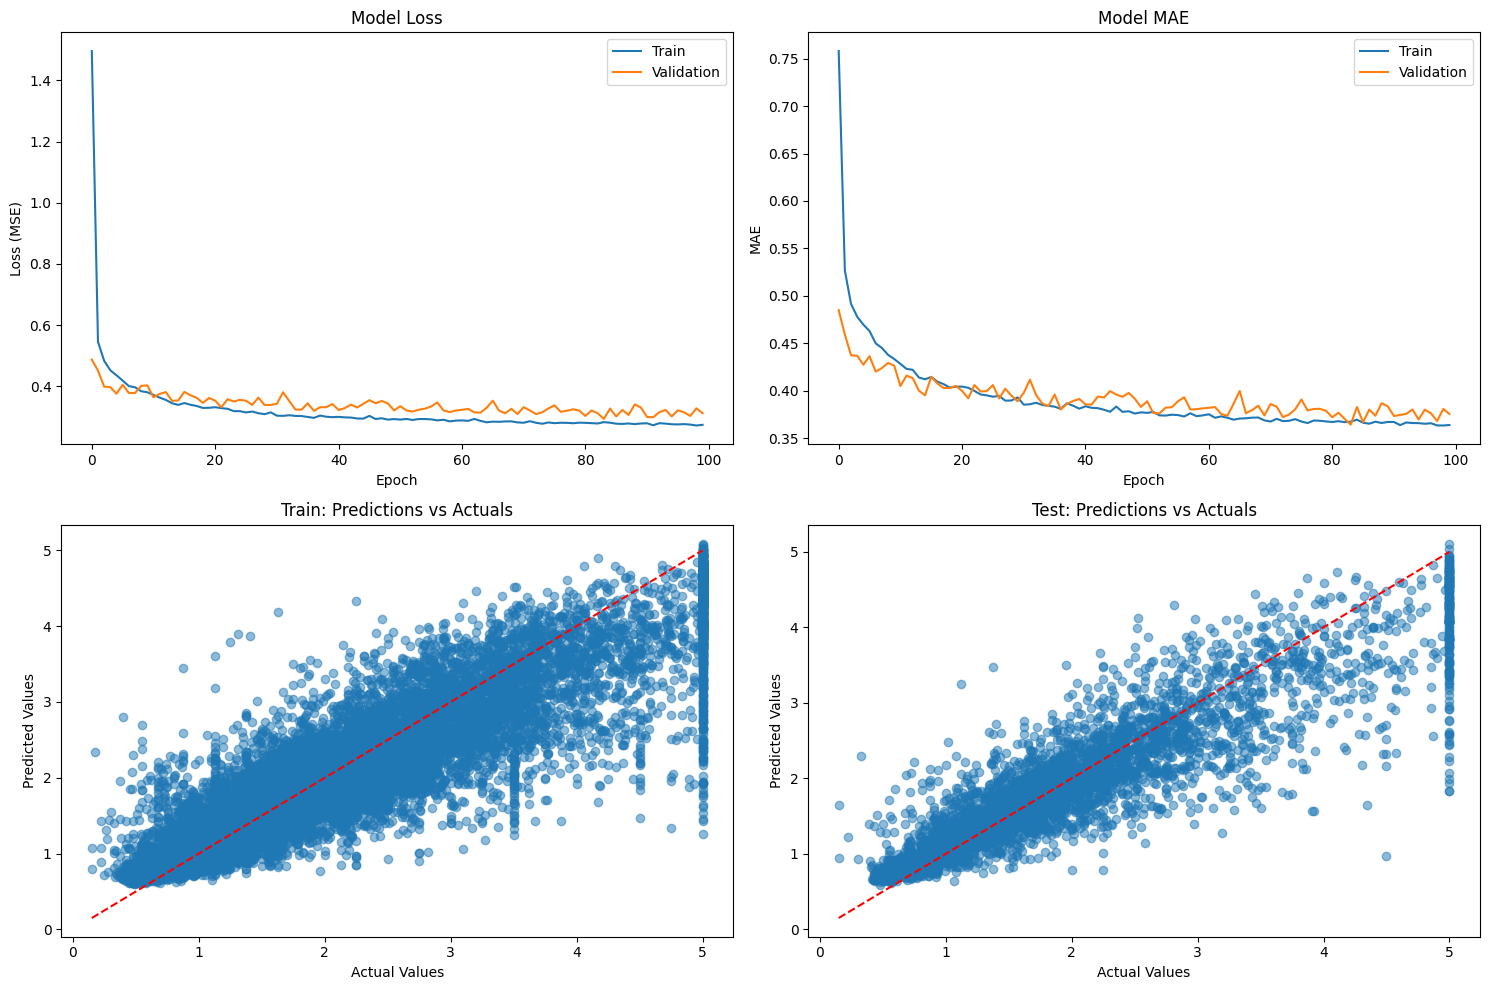

In [6]:
print("\n===== Model Evaluation =====")
print("\nTraining Data Metrics:")
print(f"MAE: {train_metrics['mae']:.4f}")
print(f"MSE: {train_metrics['mse']:.4f}")
print(f"RMSE: {train_metrics['rmse']:.4f}")
print(f"R²: {train_metrics['r2']:.4f}")
print(f"Accuracy (R² as %): {train_metrics['accuracy_percentage']:.2f}%")

print("\nTest Data Metrics:")
print(f"MAE: {test_metrics['mae']:.4f}")
print(f"MSE: {test_metrics['mse']:.4f}")
print(f"RMSE: {test_metrics['rmse']:.4f}")
print(f"R²: {test_metrics['r2']:.4f}")
print(f"Accuracy (R² as %): {test_metrics['accuracy_percentage']:.2f}%")

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(2, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(2, 2, 3)
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Train: Predictions vs Actuals')

plt.subplot(2, 2, 4)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Test: Predictions vs Actuals')

plt.tight_layout()
plt.savefig('training_history.png')

params = {
    'mean': mean,
    'std': std,
    'feature_names': feature_names,
    'train_metrics': train_metrics,
    'test_metrics': test_metrics
}

In [7]:
with open('model_params.pkl', 'wb') as f:
    pickle.dump(params, f)

with open("A01665895_regressionmodel_housing_prices_cali.pkl", "wb") as model_file:
    pickle.dump(model, model_file)